In [1]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion
TRAIN_DIR = r'E:\Machine-learning-for-Diabetic-Retinopathy\data'
TEST_DIR = r'E:\projects\research paper\plant disease detection\test_data'
IMG_SIZE = 50
LR = 1e-3

In [2]:
MODEL_NAME = 'diabeticratino-{}-{}.model'.format(LR, 'model')


In [3]:
def label_img(img):
    word_label = img[0]
  
    if word_label == '0': return [1,0,0,0]
    
    elif word_label == '1': return [0,1,0,0]
    elif word_label == '2': return [0,0,1,0]
    elif word_label == '4': return [0,0,0,1]

In [4]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [5]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [6]:
train_data = create_train_data()
# If you have already created the dataset:
#train_data = np.load('train_data.npy')


100%|██████████████████████████████████████| 3343/3343 [10:06<00:00,  5.51it/s]


In [7]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import tensorflow as tf

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [8]:
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 3], name='input')

convnet = conv_2d(convnet, 32, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)

convnet = conv_2d(convnet, 64, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)

convnet = conv_2d(convnet, 128, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)

convnet = conv_2d(convnet, 32, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)

convnet = conv_2d(convnet, 64, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 4, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [9]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [11]:
train = train_data[:-500]
test = train_data[-500:]

In [12]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
test_y = [i[1] for i in test]

In [13]:
model.fit({'input': X}, {'targets': Y}, n_epoch=20, validation_set=({'input': test_x}, {'targets': test_y}),
    snapshot_step=40, show_metric=True, run_id=MODEL_NAME)

Training Step: 899  | total loss: 1.07778 | time: 14.045s
| Adam | epoch: 020 | loss: 1.07778 - acc: 0.4968 -- iter: 2816/2843
Training Step: 900  | total loss: 1.08489 | time: 15.325s
| Adam | epoch: 020 | loss: 1.08489 - acc: 0.4955 | val_loss: 1.24051 - val_acc: 0.4280 -- iter: 2843/2843
--


In [16]:
model.save(MODEL_NAME)

INFO:tensorflow:E:\projects\research paper\plant disease detection\healthyvsunhealthy-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

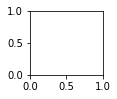

In [24]:
import matplotlib.pyplot as plt
#test_data = process_test_data()
fig = plt.figure()
test_data = np.load('test_data.npy')
'''These are the formats of the data
if word_label == 'h': return [1,0,0,0]
    
elif word_label == 'b': return [0,1,0,0]
elif word_label == 'v': return [0,0,1,0]
elif word_label == 'l': return [0,0,0,1]
'''

for num, data in enumerate(test_data[16:28]):
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4, num + 1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 3)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == np.all([1,0,0,0]):
        str_label='Healthy'
    elif np.argmax(model_out) == [0,1,0,0]:
        str_label='Bacterial'
    elif np.argmax(model_out) == [0,0,1,0]:
        str_label='Viral'
    else: str_label = 'limase'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [25]:
model.summary()

AttributeError: 'DNN' object has no attribute 'summary'